* **Grupo 7**
* **Pablo Fernández de Vicente**
* **Antonio Sevillano Martín**

#<center> **Práctica 1 Aprendizaje Automático**

## <center>**Diseño, Entrenamiento y Test de un Sistema de Redes de Neuronas Artificiales.**

**Antonio Sevillano y Pablo Fernández, 13-10-2021**

1. **Introducción**
<p style='text-align: justify;'> En esta práctica se crea un modelo de Red de Neuronas Artificiales cuyo objetivo es ser capaz de clasificar diferentes imágenes de ropa. Se utiliza el conjunto de datos de las imágenes de Zalando formado por 70K imagenes en 10 categorías en escala de grises. Están en un formato de 28x28 píxeles. El modelo se utiliza posteriormente para hacer predicciones. La intención del trabajo es hacer el modelo aplicando las librerías necesarias e interpretar los resultados. </p>
        
        
2. **Desarrollo del modelo**
<p style='text-align: justify;'> Importamos la librería "numpy" y la llamamos "np". Esta librería nos permite crear vectores y matrices de grandes dimensiones además de poder realizar una gran variedad de funciones matemáticas de alto nivel. También importamos la librería "keras" gracias a la que es posible ejecutar los modelos de Deep Learning. Puede funcionar sobre Theano o TensorFlow. Nosotros en este caso utilizamos el segundo, aseguándonos que la versión es la 2.0.0 o superior. Importamos la librería "matplotlib.pyplot" que nos permite crear y personalizar gráficos en dos dimensiones.  </p>

In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
#comprobamos la versión de keras
print(tf.keras.__version__)
#comprobamos si hay un GPU disponible para poder ejecutar e modelo
print("GPU Available:", tf.config.list_physical_devices('GPU'))
#comprobamos la versión de TensorFlow
print(tf.__version__)

2.6.0
GPU Available: []
2.6.0


<p style='text-align: justify;'> Una vez importadas las librerías principales y comprobado que su versión es superior a la 2.0.0 (en este caso 2.6.0), cargamos los datos de entrenamiento y de Test a partir de "keras.datasets.fashion_mnist". La librería contiene un set de 70K imágenes de las cuales 60K son usadas para entrenar la red neuronal y 10K para comprobar qué tan exacto es el modelo. Train_images y Train_labels los utiliza el modelo para aprender. Comprobamos la dimensión de los datos, su forma y el tipo de datos que son. 
Las imágenes son matrices con una dimensión de 28x28 de enteros de 8 bits (256 valores en escala de grises).
 </p>


In [2]:
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images.ndim, train_images.shape, train_images.dtype

4431872/4422102 [==============================] - 0s 0us/step


(3, (60000, 28, 28), dtype('uint8'))

<p style='text-align: justify;'>Para hacernos una idea de con qué imágenes vamos a trabajar pintamos con matplotlib una de ellas. En este caso el sexto elemento del tensor.
</p>


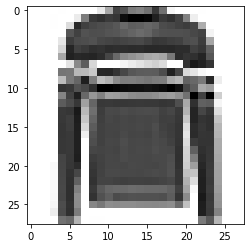

In [3]:
clothes = train_images[5]
plt.imshow(clothes, cmap=plt.cm.binary)
plt.show()

Cada imagen se corresponde con una etiqueta. Estas etiquetas no se encuentran en el dataset por lo que somos nosotros los que las tenemos que cargar. En este caso las etiquetas se corresponden con la siguiente imagen. Para cargar estas etiquetas basta con crear un array de diez dimensiones en el que la primera posición sea "T-shirt/top", la segunda "Trouser" y así hasta la última.




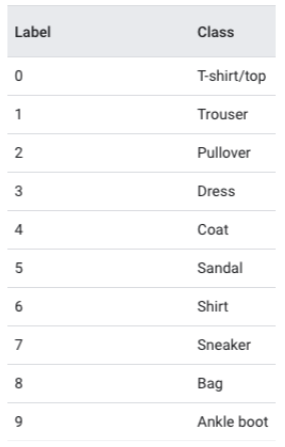

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



3. **Análisis de los datos**
<p style='text-align: justify;'> Antes de comenzar con el entrenamiento del sistema, exploramos el set de datos y comprobamos qué características tiene.
Podemos ver, entre otras cosas, cómo es el set de entrenamiento y cómo es el set de test. </p>
<p style='text-align: justify;'> En la siguiente línea de código se estudia en concreto el set de entrenamiento. Se puede ver que hay 60K imágenes para el entrenamiento y que su dimensión es de 28x28 píxeles.</p>



In [5]:
train_images.shape


(60000, 28, 28)

Además, el número de etiquetas que hay en este set es de 60K.



In [6]:
len(train_labels)


60000

Comprobamos que cada etiqueta es un número entero que se encuentra entre el 0 y el 9.

In [7]:
train_labels


array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Realizamos el mismo estudio pero con el set de test formado por 10K imágenes.


In [8]:
test_images.shape


(10000, 28, 28)

Como es lógico, el set de test tendrá el mismo número de etiquetas que de imágenes.


In [9]:
len(test_labels)


10000

4. **Preprocesado de datos**
<p style='text-align: justify;'> Antes de entrenar el sistema es necesario preprocesar los datos para que se encuentren correctamente para su utilización. </p>
<p style='text-align: justify;'> En primer lugar estudiamos una de las imágenes del set de entrenamiento, por ejemplo la de la posición [5] que hemos comprobado antes. Los valores de los píxeles van a estar entre 0 y 255, que se corresponden con los 256 valores en escala de grises.</p>


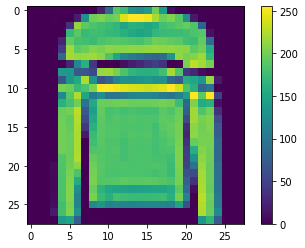

In [10]:
plt.figure()
plt.imshow(train_images[5])
plt.colorbar()
plt.grid(False)
plt.show()

Dividimos los valores tanto de las imágenes de entrenamiento como de las imágenes de test entre 255 para que sus valores se encuentren en un rango de entre 0 y 1. Además comprobamos las primeras 25 imágenes del set de entrenamiento con su correspondiente etiqueta para comprobar si el set de datos está en el formato adecuado.

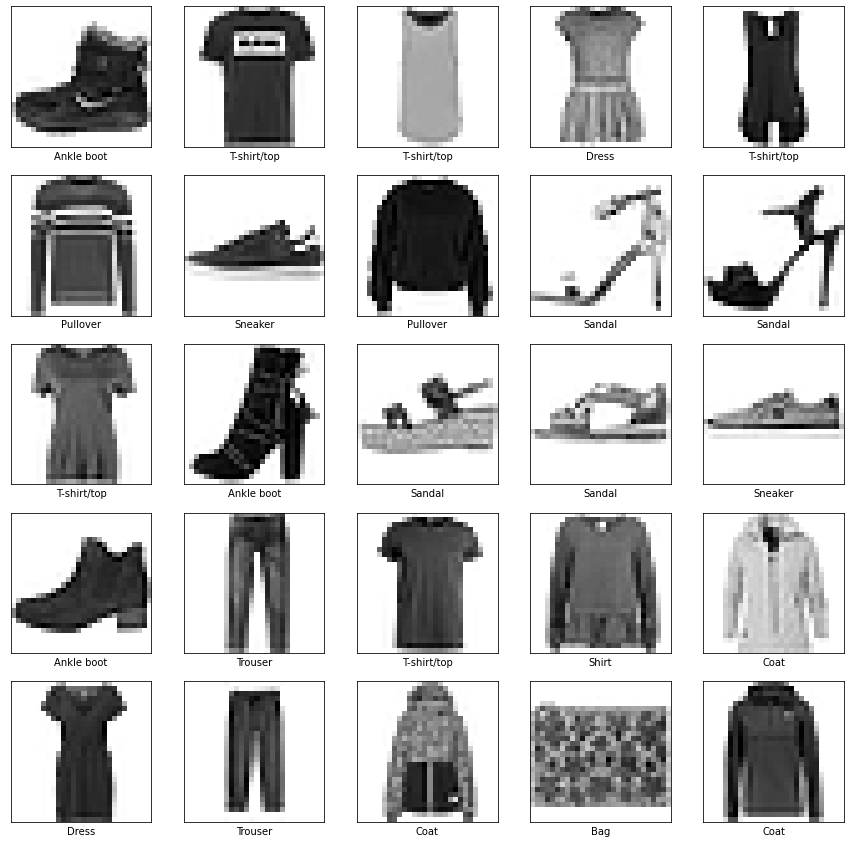

In [11]:
train_images = train_images / 255.0
test_images = test_images / 255.0

plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

**Construcción de los modelos**
<p style='text-align: justify;'> Para construir la red neuronal hay que configurar las capas del modelo. Utilizamos la función keras.layers.Flatten() que convierte las imágenes en un vector de 784 píxeles (resulta de la multiplicación de 28x28). Esta capa no aprende ningún parámetro, simplemente reformatea el set de datos. Se puede observar como una capa en la misma imagen no apilada de filas de píxeles. </p>

<p style='text-align: justify;'>En todos los modelos utilizamos la función de pérdida "sparse_categorical_crossentropy", la métrica de precisión y 5 épocas. </p>
<p style='text-align: justify;'>Es importante resaltar que la función 
"sparse_categorical_crossentropy" y "categorical_crossentropy" realizan la misma función de pérdida; se utiliza una u otra dependiendo de la forma en que se cargan los datos. La primera funciona con enteros y la segunda con valores one-hot codificados. </p>
<p style='text-align: justify;'>También hay que destacar que cada vez que se ejecuta el programa los resultados obtenidos son algo distintos porque los pesos con los que las neuronas trabajan son aleatorios. Es por esto que al comparar los datos recogidos en la memoria con los datos de la ejecución pueden ser distintos. </p>

* **Modelo 1. Neuronas en la primera capa: 10. Función de activación: "relu". Optimizador: "sgd"**

<p style='text-align: justify;'> La red está formada por dos capas. La primera capa dense tiene 10 neuronas y su función de activación es "relu". La segunda capa es una una capa "softmax" con diez nodos y devuelve un vector con 10 probabilidades que suman 1. Este vector indica la probabilidad de que la imagen pertenezca a una de las 10 clases. Además utilizamos el optimizador "sgd".   </p>

In [12]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1.fit(train_images, train_labels, epochs=5)


Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.9108 - accuracy: 0.6851
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5586 - accuracy: 0.8091
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5015 - accuracy: 0.8269
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4766 - accuracy: 0.8348
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4606 - accuracy: 0.8402



<p style='text-align: justify;'>Como se puede observar, el modelo alcanza una exactitud de 0.8368, es decir, del 83.68% sobre el set de datos de entrenamiento. </p>
<p style='text-align: justify;'>Una vez obtenido el resultado de los datos de entrenamiento, lo comparamos con los datos de test. Utilizamos el comando "model.summary()" que realiza un resumen de la estructura de la red neuronal. </p>


In [13]:
test_loss, test_acc = model1.evaluate(test_images,  test_labels, verbose=2)
print(model1.summary())

313/313 - 0s - loss: 0.4817 - accuracy: 0.8317
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
None


<p style='text-align: justify;'>El "model.summary()" permite ver cómo es la red neuronal. En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. En la segunda capa de activación "relu" indica que se utilizan 10 neuronas y el número de parámetros aprendido es 7850 que es el resultado de multiplicar 785x10, siendo 785 el número de parámetros que hay entre [0,...,784] y 10 el número de neuronas. Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 110.</p>
<p style='text-align: justify;'>Como se puede observar, el total de parámetros entrenados es 7960 que es el resultado de sumar los 7850 parámetros más 110. </p>


**Evaluamos el sistema**



In [14]:
test_loss, test_acc = model1.evaluate(test_images,  test_labels, verbose=2)

print('\nPrecisión de los datos de test:', test_acc)


313/313 - 0s - loss: 0.4817 - accuracy: 0.8317

Precisión de los datos de test: 0.8317000269889832


La precisión del set de test es algo menor 82.13%, que la exactitud del set de entrenamiento, 83,69%. Esto significa que hay sobre entrenamiento porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.

**Predicción para la sexta imagen** 
<p style='text-align: justify;'>Utilizamos el modelo para hacer predicciones sobre las imágenes una vez que está entrenado. </p>

In [15]:
predictions = model1.predict(test_images)


En este caso, hacemos una predicción sobre la sexta imagen. Obtenemos un vector de dimensión 10 (de 0 a 9) en el que se representan los niveles de confianza del modelo sobre cada uno de los artículos de ropa. En este caso el nivel más alto de confianza es 9.89e^(-01) que se corresponde con la posición [1] del vector. Comprobando las etiquetas observamos que esta posición corresponde a la etiqueta "trousers", luego el máximo nivel de confianza del modelo será con los pantalones. Por su parte, el mínimo nivel de confianza lo compartirían "sandal" y "ankleboot" con 8.88e^(-08) y 1.85e^(-08) respectivamente.

In [ ]:
predictions[5]

array([9.2214666e-04, 9.9270862e-01, 8.6750177e-04, 5.8330083e-04,
       4.8888763e-03, 8.8887461e-08, 2.2635111e-05, 2.4801173e-07,
       6.6304983e-06, 1.8514566e-08], dtype=float32)

**Graficamos el comportamiento del modelo**


Creamos dos funciones, "plot_image" y "plot_value_array" que nos permiten graficar cómo de bien o cómo de mal se comporta el modelo. Estas funciones las vamos a utilizar en los 8 modelos pero con definirlas una única vez es suficiente para poder graficar los diferentes modelos.

In [17]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')


En este caso, miramos la imagen [6], con el vector de sus predicciones y sus predicciones. Las etiquetas correctas se encuentran en verde y las incorrectas en rojo. Se entrega el porcentaje sobre la etiqueta que se está prediciendo


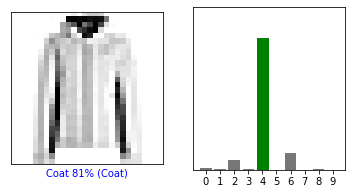

In [18]:
i = 6
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()


<p style='text-align: justify;'>Podemos observar cómo acierta con un 76% de precisión que es un abrigo. Además, la red neuronal tiene cierto problema con las posiciones [2] y [6] que se corresponden con "pullover" y "shirt" respectivamente. Tiene bastante sentido porque las tres prendas son parecidas. </p>
<p style='text-align: justify;'>Lo comprobamos para las 10 primeras imágenes del conjunto test. </p>

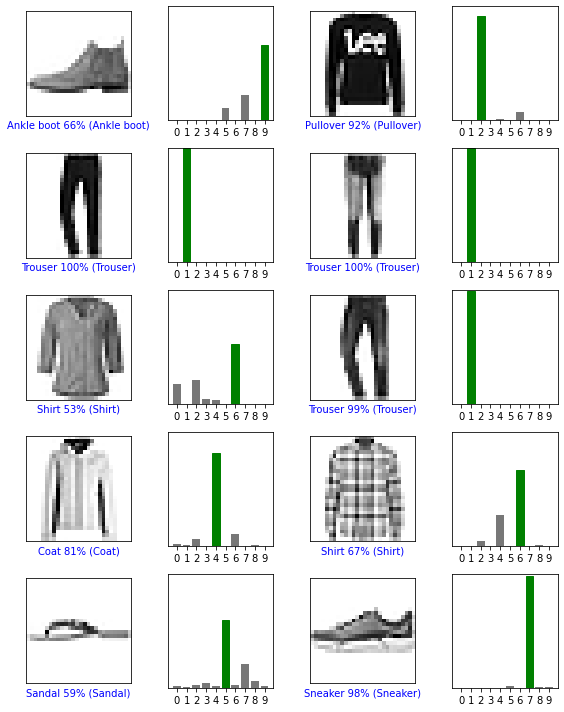

In [21]:
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Observando las diez primeras imágenes nos damos cuenta de que la red neuronal con los pantalones no tiene ningún problema mientras que con las camisetas o las botas de tobillo sí que puede tener alguna equivocación más. Sin embargo todas salen en verde lo que significa que no hay ninguna imagen con la que tenga más equivocaciones que aciertos. Esto pasaría si alguna de las barras fuera roja. Estos resultados indican que las imágenes que ya conoce la red neuronal las domina perfectamente. Sin embargo, sí que sufre algún problema más con imágenes que no ha visto nunca y es que este modelo este un poco sobreentrenado. Como las épocas en que se ha aplica la red son solo 5, el sobreentreamiento es pequeño, pero si se le aplicara más épocas al modelo este aumentaría.

* **Modelo 2. Neuronas en la primera capa: 10. Función de activación: "relu". Optimizador: "rmsprop"**

La red está formada por dos capas. La primera capa dense tiene 10 neuronas y su función de activación es "relu". La segunda capa es una una capa "softmax" con diez nodos y devuelve un vector con 10 probabilidades que suman 1. Este vector indica la probabilidad de que la imagen pertenezca a una de las 10 clases. Además utilizamos el optimizador "rmsprop".


In [22]:
model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model2.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(train_images, train_labels, epochs=5)

test_loss, test_acc = model2.evaluate(test_images,  test_labels, verbose=2)
print(model2.summary())


Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6299 - accuracy: 0.7840
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4571 - accuracy: 0.8389
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4310 - accuracy: 0.8484
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4191 - accuracy: 0.8538
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4117 - accuracy: 0.8555
313/313 - 0s - loss: 0.4558 - accuracy: 0.8401
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_3 (Dense)              (

El "model.summary()" permite ver cómo es la red neuronal. En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. En la segunda capa de activación "relu" indica que se utilizan 10 neuronas y el número de parámetros aprendido es 7850 que es el resultado de multiplicar 785x10, siendo 785 el número de parámetros que hay entre [0,...,784] y 10 el número de neuronas. Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 110.

Como se puede observar, el total de parámetros entrenados es 7960 que es el resultado de sumar los 7850 más 110.

**Evaluamos el sistema**


In [23]:
test_loss, test_acc = model2.evaluate(test_images,  test_labels, verbose=2)

print('\nPrecisión de los datos de test:', test_acc)


313/313 - 0s - loss: 0.4558 - accuracy: 0.8401

Precisión de los datos de test: 0.8400999903678894


La precisión del set de test es algo menor 84.44%, que la exactitud del set de entrenamiento, 85.46%. Esto significa que hay sobre entrenamiento porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.

**Predicción para la sexta imagen** 


In [24]:
predictions = model2.predict(test_images)

En este caso, hacemos una predicción sobre la sexta imagen. Obtenemos un vector de dimensión 10 (de 0 a 9) en el que se representan los niveles de confianza del modelo sobre cada uno de los artículos de ropa. En este caso el nivel más alto de confianza es 9.95e^(-1) que se corresponde con la posición [1] del vector. Comprobando las etiquetas observamos que esta posición corresponde a la etiqueta "trousers", luego el máximo nivel de confianza del modelo será con los pantalones como pasa con el modelo 1. Es curioso que el mínimo nivel de confianza como en el anterior modelo, también ocurre con las sandalias pero en esta ocasión, el orden de magnitud es 6 veces más pequeño (10^-14). Además, las "sneakers" también tienen menos precisión.


In [25]:
predictions[5]


array([1.5854222e-03, 9.9613899e-01, 3.4406129e-04, 3.1155432e-04,
       1.3926983e-03, 2.0077173e-11, 1.3575306e-04, 3.6335092e-15,
       9.1490030e-05, 2.0650526e-09], dtype=float32)

**Graficamos el comportamiento del modelo**


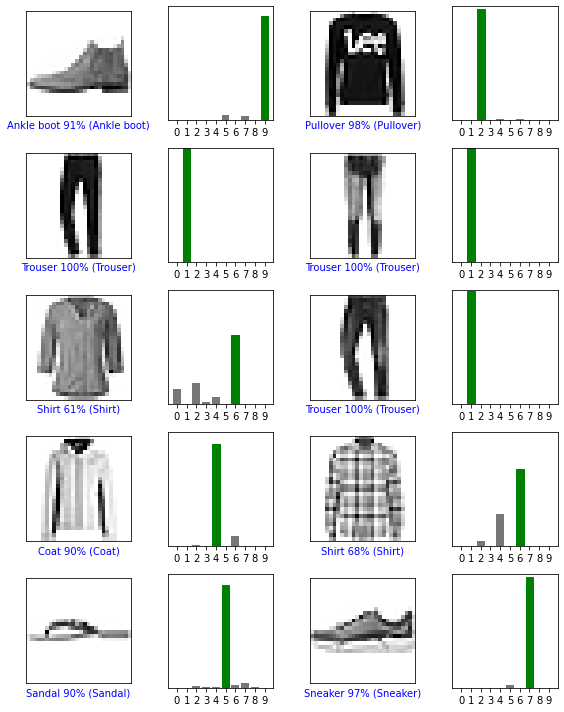

In [26]:
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Observando las diez primeras imágenes nos damos cuenta de que la red neuronal con los pantalones no tiene ningún problema mientras que con las camisetas, las zapatillas y las chanclas tiene algún que otro error, mientras que con las botas de tobillo sí que puede tener alguna equivocación más. Sin embargo todas salen en verde lo que significa que no hay ninguna imagen con la que tenga más equivocaciones que aciertos.

 **Modelo 3. Neuronas en la primera capa: 10. Función de activación: "sigmoid". Optimizador: "sgd"**


La red está formada por dos capas. La primera capa dense tiene 10 neuronas y su función de activación es "sigmoid". La segunda capa es una una capa "softmax" con diez nodos y devuelve un vector con 10 probabilidades que suman 1. Este vector indica la probabilidad de que la imagen pertenezca a una de las 10 clases. Además utilizamos el optimizador "sgd".

In [27]:
model3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])

model3.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.fit(train_images, train_labels, epochs=5)

test_loss, test_acc = model3.evaluate(test_images,  test_labels, verbose=2)
print(model3.summary())


Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 1.6852 - accuracy: 0.5185
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 1.1257 - accuracy: 0.7026
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.9070 - accuracy: 0.7382
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7972 - accuracy: 0.7535
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7286 - accuracy: 0.7630
313/313 - 0s - loss: 0.7174 - accuracy: 0.7562
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_5 (Dense)              (

El "model.summary()" permite ver cómo es la red neuronal. En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. En la segunda capa de activación "sigmoid" indica que se utilizan 10 neuronas y el número de parámetros aprendido es 7850 que es el resultado de multiplicar 785x10, siendo 785 el número de parámetros que hay entre [0,...,784] y 10 el número de neuronas. Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 110.

Como se puede observar, el total de parámetros entrenados es 7960 que es el resultado de sumar los 7850 más 110.

**Evaluamos el sistema**


In [28]:
test_loss, test_acc = model3.evaluate(test_images,  test_labels, verbose=2)

print('\nPrecisión de los datos de test:', test_acc)


313/313 - 0s - loss: 0.7174 - accuracy: 0.7562

Precisión de los datos de test: 0.7562000155448914


La precisión del set de test es algo menor 75.26%, que la exactitud del set de entrenamiento, 75.49%. Esto significa que hay sobre entrenamiento porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.

**Predicción para la sexta imagen** 


In [29]:
predictions = model3.predict(test_images)

In [30]:
predictions[5]


array([2.0795908e-02, 9.0803409e-01, 3.9671795e-03, 3.2954156e-02,
       1.3467760e-02, 6.6662775e-03, 1.1862020e-02, 3.5926854e-04,
       1.6889084e-03, 2.0455175e-04], dtype=float32)

Comprobando los ordenes de magnitud del vector se puede observar que todos son muy altos (el menor 10^-5) comparado con los dos modelos anteriores. Esto indica que la red neuronal, a la hora de aplicar el set de imágenes de test, tiene una precisión muy grande.

**Graficamos el comportamiento del modelo**


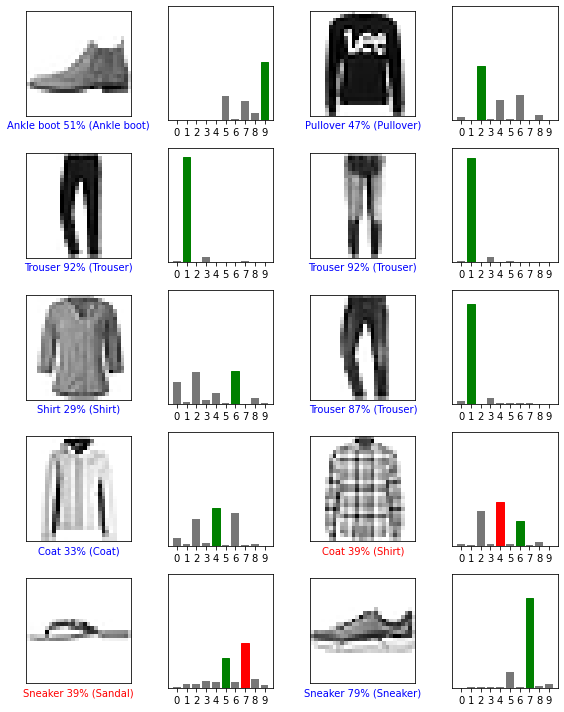

In [ ]:
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Observando las diez primeras imágenes nos damos cuenta de que la red neuronal con los pantalones y las zapatillas tiene algún que otro problema, con el abrigo y con la camisa acierta un tercio de las veces, las sudaderas y las botas de tobillo acierta en la mitad ellas, mientras que con el abrigo (camisa) y con las chanclas tiene más errores que aciertos, es decir la red de neuronas no detecta bien dichos elemntos.

* **Modelo 4. Neuronas en la primera capa: 10. Función de activación: "sigmoid". Optimizador: "rmsprop"**


La red está formada por dos capas. La primera capa dense tiene 10 neuronas y su función de activación es "sigmoid". La segunda capa es una una capa "softmax" con diez nodos y devuelve un vector con 10 probabilidades que suman 1. Este vector indica la probabilidad de que la imagen pertenezca a una de las 10 clases. Además utilizamos el optimizador "rmsprop".

In [31]:
model4 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])

model4.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model4.fit(train_images, train_labels, epochs=5)

test_loss, test_acc = model4.evaluate(test_images,  test_labels, verbose=2)
print(model4.summary())


Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0008 - accuracy: 0.7176
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5507 - accuracy: 0.8204
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4742 - accuracy: 0.8376
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4439 - accuracy: 0.8452
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4266 - accuracy: 0.8526
313/313 - 0s - loss: 0.4601 - accuracy: 0.8392
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_7 (Dense)              (

El "model.summary()" permite ver cómo es la red neuronal. En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. En la segunda capa de activación "sigmoid" indica que se utilizan 10 neuronas y el número de parámetros aprendido es 7850 que es el resultado de multiplicar 785x10, siendo 785 el número de parámetros que hay entre [0,...,784] y 10 el número de neuronas. Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 110.

Como se puede observar, el total de parámetros entrenados es 7960 que es el resultado de sumar los 7850 más 110.

**Evaluamos el sistema**


In [32]:
test_loss, test_acc = model4.evaluate(test_images,  test_labels, verbose=2)

print('\nPrecisión de los datos de test:', test_acc)


313/313 - 0s - loss: 0.4601 - accuracy: 0.8392

Precisión de los datos de test: 0.8392000198364258


La precisión del set de test es algo menor 84.11%, que la exactitud del set de entrenamiento, 85.54%. Esto significa que hay sobre entrenamiento porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.

**Predicción para la sexta imagen** 


In [33]:
predictions = model4.predict(test_images)

En este caso, hacemos una predicción sobre la sexta imagen. Obtenemos un vector de dimensión 10 (de 0 a 9) en el que se representan los niveles de confianza del modelo sobre cada uno de los artículos de ropa. En este caso el nivel más alto de confianza es 9.80e^(-1) que se corresponde con la posición [1] del vector. Comprobando las etiquetas observamos que esta posición corresponde a la etiqueta "trousers", luego el máximo nivel de confianza del modelo será con los pantalones.


In [34]:
predictions[5]

array([2.7459639e-03, 9.8747706e-01, 3.1458185e-04, 2.1480531e-03,
       3.1756144e-03, 9.1386237e-06, 3.6688750e-03, 1.4574853e-06,
       3.8491393e-04, 7.4289157e-05], dtype=float32)

**Graficamos el comportamiento del modelo**


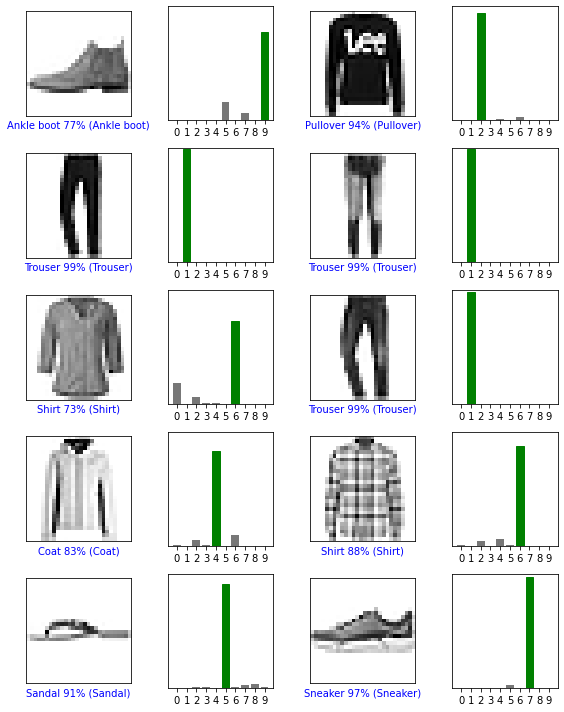

In [35]:
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Observando las diez primeras imágenes nos damos cuenta de que la red neuronal con los pantalones y con las zapatillas no tiene ningún problema mientra que con las camisetas,los abrigos y las chanclas tiene algún que otro error, mientras que con las botas de tobillo sí que puede tener alguna equivocación más. Sin embargo todas salen en verde lo que significa que no hay ninguna imagen con la que tenga más equivocaciones que aciertos. Esto pasaría si alguna de las barras fuera roja.

* **Modelo 5. Neuronas en la primera capa: 512. Función de activación: "relu". Optimizador: "sgd"**


La red está formada por dos capas. La primera capa dense tiene 512 neuronas y su función de activación es "relu". La segunda capa es una una capa "softmax" con diez nodos y devuelve un vector con 10 probabilidades que suman 1. Este vector indica la probabilidad de que la imagen pertenezca a una de las 10 clases. Además utilizamos el optimizador "sgd".

In [36]:
model5 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model5.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model5.fit(train_images, train_labels, epochs=5)

test_loss, test_acc = model5.evaluate(test_images,  test_labels, verbose=2)
print(model5.summary())


Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7086 - accuracy: 0.7735
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4975 - accuracy: 0.8321
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4555 - accuracy: 0.8439
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4317 - accuracy: 0.8507
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4130 - accuracy: 0.8579
313/313 - 1s - loss: 0.4394 - accuracy: 0.8461
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_9 (Dense)              (

El "model.summary()" permite ver cómo es la red neuronal. En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. En la segunda capa de activación "relu" indica que se utilizan 512 neuronas y el número de parámetros aprendido es 401920 que es el resultado de multiplicar 785x512, siendo 401920 el número de parámetros que hay entre [0,...,784] y 512 el número de neuronas. Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 5130.

Como se puede observar, el total de parámetros entrenados es 407050 que es el resultado de sumar los 401920 más 5130.

**Evaluamos el sistema**


In [37]:
test_loss, test_acc = model5.evaluate(test_images,  test_labels, verbose=2)

print('\nPrecisión de los datos de test:', test_acc)


313/313 - 1s - loss: 0.4394 - accuracy: 0.8461

Precisión de los datos de test: 0.8460999727249146


La precisión del set de test es algo menor 84.40%, que la exactitud del set de entrenamiento, 85.73%. Esto significa que hay sobre entrenamiento porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.

**Predicción para la sexta imagen** 


In [38]:
predictions = model5.predict(test_images)

In [39]:
predictions[5]

array([4.5938673e-03, 9.8986477e-01, 2.6204961e-04, 7.8091415e-04,
       4.3860730e-03, 2.5319358e-07, 8.6596789e-05, 2.1263704e-06,
       2.3305565e-05, 1.1160781e-07], dtype=float32)

**Graficamos el comportamiento del modelo**


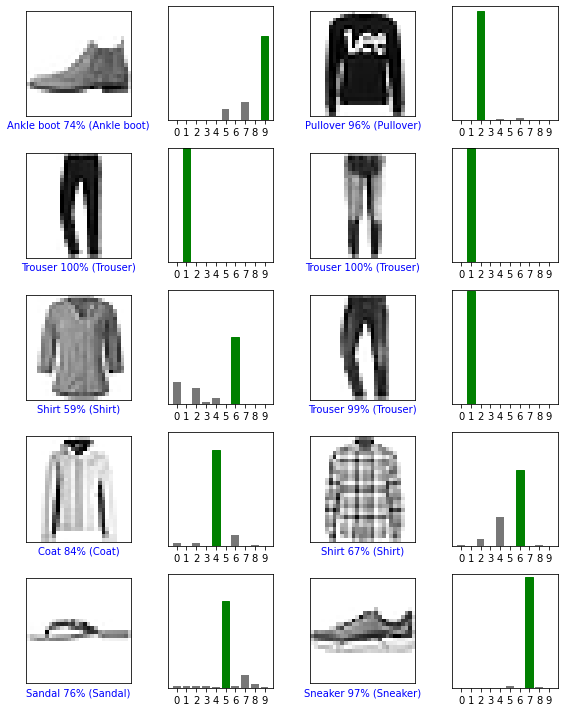

In [40]:
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Observando las diez primeras imágenes nos damos cuenta de que la red neuronal con los pantalones y con las zapatillas no tiene ningún problema mientra que con la sudadera y las chanclas tiene algún que otro error, mientras que con las botas de tobillo, la camisa y los abrigos sí que puede tener alguna equivocación más. Sin embargo todas salen en verde lo que significa que no hay ninguna imagen con la que tenga más equivocaciones que aciertos. Esto pasaría si alguna de las barras fuera roja.

* **Modelo 6. Neuronas en la primera capa: 512. Función de activación: "relu". Optimizador: "rmsprop"**


La red está formada por dos capas. La primera capa dense tiene 512 neuronas y su función de activación es "relu". La segunda capa es una una capa "softmax" con diez nodos y devuelve un vector con 10 probabilidades que suman 1. Este vector indica la probabilidad de que la imagen pertenezca a una de las 10 clases. Además utilizamos el optimizador "rmsprop".

In [41]:
model6 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model6.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model6.fit(train_images, train_labels, epochs=5)

test_loss, test_acc = model6.evaluate(test_images,  test_labels, verbose=2)
print(model6.summary())


Epoch 1/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4949 - accuracy: 0.8229
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3795 - accuracy: 0.8662
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3547 - accuracy: 0.8758
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3406 - accuracy: 0.8846
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3285 - accuracy: 0.8887
313/313 - 1s - loss: 0.4106 - accuracy: 0.8689
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_11 (Dense)         

El "model.summary()" permite ver cómo es la red neuronal. En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. En la segunda capa de activación "relu" indica que se utilizan 512 neuronas y el número de parámetros aprendido es 401920 que es el resultado de multiplicar 785x512, siendo 401920 el número de parámetros que hay entre [0,...,784] y 512 el número de neuronas. Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 5130.

Como se puede observar, el total de parámetros entrenados es 407050 que es el resultado de sumar los 401920 más 5130.

**Evaluamos el sistema**


In [42]:
test_loss, test_acc = model6.evaluate(test_images,  test_labels, verbose=2)

print('\nPrecisión de los datos de test:', test_acc)


313/313 - 1s - loss: 0.4106 - accuracy: 0.8689

Precisión de los datos de test: 0.8689000010490417


La precisión del set de test es algo menor 86.34%, que la exactitud del set de entrenamiento, 88.86%. Esto significa que hay sobre entrenamiento porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.

**Predicción para la sexta imagen** 


In [43]:
predictions = model6.predict(test_images)

En este caso, hacemos una predicción sobre la sexta imagen. Obtenemos un vector de dimensión 10 (de 0 a 9) en el que se representan los niveles de confianza del modelo sobre cada uno de los artículos de ropa. En este caso el nivel más alto de confianza es 9.99e^(-1) que se corresponde con la posición [1] del vector. Comprobando las etiquetas observamos que esta posición corresponde a la etiqueta "trousers", luego el máximo nivel de confianza del modelo será con los pantalones.


In [44]:
predictions[5]

array([3.8419509e-10, 1.0000000e+00, 3.1857129e-15, 3.3371954e-09,
       4.8875520e-10, 8.2597617e-17, 6.1041749e-12, 5.4227987e-24,
       9.9575084e-18, 1.9974501e-23], dtype=float32)

**Graficamos el comportamiento del modelo**


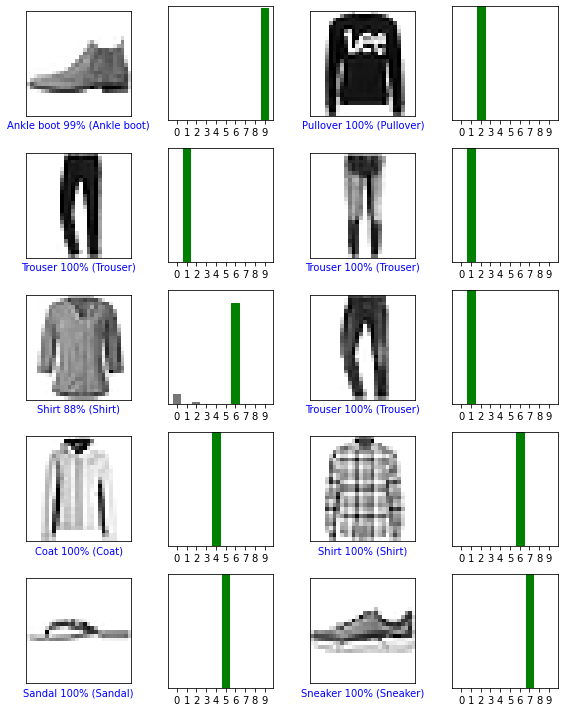

In [45]:
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Observando las diez primeras imágenes nos damos cuenta de que la red neuronal con los pantalones, con el calzado, la sudadera y el abrigo acierta al 100%, mientras que con las camisetas detecta más de la mitad de forma erronea. Por lo tanto, a excepción de las camisetas no hay ninguna imagen que tenga más equivocaciones que aciertos.

* **Modelo 7. Neuronas en la primera capa: 512. Función de activación: "sigmoid". Optimizador: "sgd"**


La red está formada por dos capas. La primera capa dense tiene 512 neuronas y su función de activación es "sigmoid". La segunda capa es una una capa "softmax" con diez nodos y devuelve un vector con 10 probabilidades que suman 1. Este vector indica la probabilidad de que la imagen pertenezca a una de las 10 clases. Además utilizamos el optimizador "sgd".

In [46]:
model7 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(512, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])

model7.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model7.fit(train_images, train_labels, epochs=5)

test_loss, test_acc = model7.evaluate(test_images,  test_labels, verbose=2)
print(model7.summary())


Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 1.1473 - accuracy: 0.6761
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7141 - accuracy: 0.7597
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6262 - accuracy: 0.7833
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5790 - accuracy: 0.7983
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5480 - accuracy: 0.8091
313/313 - 1s - loss: 0.5554 - accuracy: 0.8034
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_13 (Dense)             (

El "model.summary()" permite ver cómo es la red neuronal. En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. En la segunda capa de activación "sigmoid" indica que se utilizan 512 neuronas y el número de parámetros aprendido es 401920 que es el resultado de multiplicar 785x512, siendo 401920 el número de parámetros que hay entre [0,...,784] y 512 el número de neuronas. Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 5130.

Como se puede observar, el total de parámetros entrenados es 407050 que es el resultado de sumar los 401920 más 5130.

**Evaluamos el sistema**


In [47]:
test_loss, test_acc = model7.evaluate(test_images,  test_labels, verbose=2)

print('\nPrecisión de los datos de test:', test_acc)


313/313 - 1s - loss: 0.5554 - accuracy: 0.8034

Precisión de los datos de test: 0.8033999800682068


La precisión del set de test es algo menor 79.73%, que la exactitud del set de entrenamiento, 80.86%. Esto significa que hay sobre entrenamiento porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.

**Predicción para la sexta imagen** 


In [48]:
predictions = model7.predict(test_images)

En este caso, hacemos una predicción sobre la sexta imagen. Obtenemos un vector de dimensión 10 (de 0 a 9) en el que se representan los niveles de confianza del modelo sobre cada uno de los artículos de ropa. En este caso el nivel más alto de confianza es 9.62e^(-1) que se corresponde con la posición [1] del vector. Comprobando las etiquetas observamos que esta posición corresponde a la etiqueta "trousers", luego el máximo nivel de confianza del modelo será con los pantalones.

In [49]:
predictions[5]

array([5.9033688e-03, 9.6562684e-01, 2.0635657e-03, 4.2749797e-03,
       2.0381264e-02, 4.4997360e-06, 1.7008099e-03, 1.1388931e-05,
       2.8436441e-05, 4.8646416e-06], dtype=float32)

**Graficamos el comportamiento del modelo**


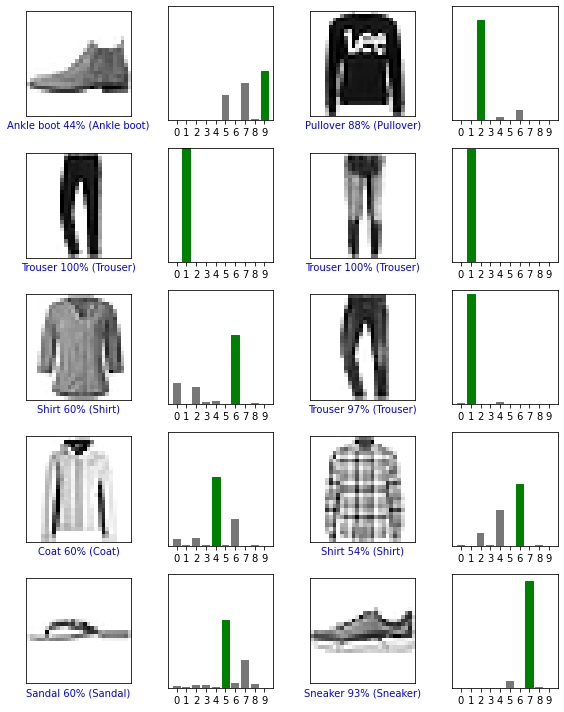

In [50]:
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Observando las diez primeras imágenes nos damos cuenta de que la red neuronal con los pantalones y con las zapatillas no tiene ningún problema mientra que con las camisetas,los abrigos, los botines de tobillo y las chanclas tiene algún que otro error. Sin embargo todas salen en verde lo que significa que no hay ninguna imagen con la que tenga más equivocaciones que aciertos. Esto pasaría si alguna de las barras fuera roja.

* **Modelo 8. Neuronas en la primera capa: 512. Función de activación: "sigmoid". Optimizador: "rmsprop"**


La red está formada por dos capas. La primera capa dense tiene 512 neuronas y su función de activación es "sigmoid". La segunda capa es una una capa "softmax" con diez nodos y devuelve un vector con 10 probabilidades que suman 1. Este vector indica la probabilidad de que la imagen pertenezca a una de las 10 clases. Además utilizamos el optimizador "rmsprop".

In [51]:
model8 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(512, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])

model8.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model8.fit(train_images, train_labels, epochs=5)

test_loss, test_acc = model8.evaluate(test_images,  test_labels, verbose=2)
print(model8.summary())


Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5055 - accuracy: 0.8182
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3820 - accuracy: 0.8626
Epoch 3/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3447 - accuracy: 0.8751
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3214 - accuracy: 0.8829
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3018 - accuracy: 0.8905
313/313 - 1s - loss: 0.3544 - accuracy: 0.8758
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_15 (Dense)         

El "model.summary()" permite ver cómo es la red neuronal. En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. En la segunda capa de activación "relu" indica que se utilizan 512 neuronas y el número de parámetros aprendido es 401920 que es el resultado de multiplicar 785x512, siendo 401920 el número de parámetros que hay entre [0,...,784] y 512 el número de neuronas. Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 5130.

Como se puede observar, el total de parámetros entrenados es 407050 que es el resultado de sumar los 401920 más 5130.

**Evaluamos el sistema**


In [52]:
test_loss, test_acc = model8.evaluate(test_images,  test_labels, verbose=2)

print('\nPrecisión de los datos de test:', test_acc)


313/313 - 1s - loss: 0.3544 - accuracy: 0.8758

Precisión de los datos de test: 0.8758000135421753


La precisión del set de test es algo menor 87.48%, que la exactitud del set de entrenamiento, 89.00%. Esto significa que hay sobre entrenamiento porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.

**Predicción para la sexta imagen** 


In [53]:
predictions = model8.predict(test_images)

En este caso, hacemos una predicción sobre la sexta imagen. Obtenemos un vector de dimensión 10 (de 0 a 9) en el que se representan los niveles de confianza del modelo sobre cada uno de los artículos de ropa. En este caso el nivel más alto de confianza es 9.98e^(-1) que se corresponde con la posición [1] del vector. Comprobando las etiquetas observamos que esta posición corresponde a la etiqueta "trousers", luego el máximo nivel de confianza del modelo será con los pantalones.

In [54]:
predictions[5]

array([7.4542470e-05, 9.9991822e-01, 4.3628643e-07, 2.5640902e-06,
       1.3951609e-06, 5.1674935e-11, 2.7619501e-06, 5.5135256e-09,
       2.1128812e-08, 5.3465316e-13], dtype=float32)

**Graficamos el comportamiento del modelo**


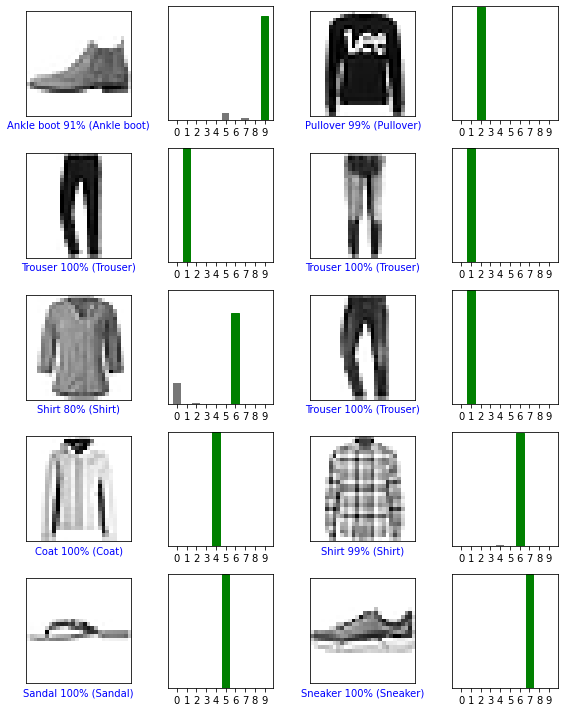

In [55]:
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Observando las diez primeras imágenes nos damos cuenta de que la red neuronal detecta siempre la prenda de ropa correcta, a excepción de la camiseta y de las botas de tobillo. Lo que nos lleva a pensar que el modelo esstá sobreentrenado puesto que con las imágenes de entrenamiento tiene un error ínfimo.

**Multiplicamos por 5 las épocas de entrenamiento (25 épocas) de los modelos 2 y 7**

In [56]:
model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model2.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(train_images, train_labels, epochs=25)

test_loss, test_acc = model2.evaluate(test_images,  test_labels, verbose=2)
print(model2.summary())


Epoch 1/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6443 - accuracy: 0.7799
Epoch 2/25
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4723 - accuracy: 0.8394
Epoch 3/25
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4433 - accuracy: 0.8486
Epoch 4/25
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4284 - accuracy: 0.8530
Epoch 5/25
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4166 - accuracy: 0.8572
Epoch 6/25
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4077 - accuracy: 0.8595
Epoch 7/25
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4023 - accuracy: 0.8616
Epoch 8/25
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3959 - accuracy: 0.8637
Epoch 9/25
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3902 - accuracy: 0.8656
Epoch 10/25
1875/1875 [==============================] - 2s 1ms/step - loss: 0.386

Evaluamos el sistema

In [57]:
test_loss, test_acc = model2.evaluate(test_images,  test_labels, verbose=2)

print('\nPrecisión de los datos de test:', test_acc)

313/313 - 0s - loss: 0.4638 - accuracy: 0.8471

Precisión de los datos de test: 0.847100019454956


**Comparación del Modelo 2 con el Modelo 2 multiplicado por 5 las épocas de entrenamiento**

### *En el antiguo Modelo 2 observamos los siguientes datos:*
-La precisión del set de test es algo menor 84.44%, que la exactitud del set de entrenamiento, 85.46%. Esto significa que hay sobre entrenamiento porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.

-En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. 

-En la segunda capa de activación "relu" indica que se utilizan 10 neuronas y el número de parámetros aprendido es 7850 que es el resultado de multiplicar 785x10, siendo 785 el número de parámetros que hay entre [0,...,784] y 10 el número de neuronas. 

-Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 110.
Como se puede observar, el total de parámetros entrenados es 7960 que es el resultado de sumar los 7850 más 110.
### *En el nuevo Modelo 2 observamos los siguientes datos:*
-La precisión del set de test es algo menor 84.95%, que la exactitud del set de entrenamiento, 87.24%. Esto significa que hay sobre entrenamiento porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.

-En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. 

-En la segunda capa de activación "relu" indica que se utilizan 10 neuronas y el número de parámetros aprendido es 7850 que es el resultado de multiplicar 785x10, siendo 785 el número de parámetros que hay entre [0,...,784] y 10 el número de neuronas. 

-Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 110.
Como se puede observar, el total de parámetros entrenados es 7960 que es el resultado de sumar los 7850 más 110.

### *Comparación:*
Podemos observar que ambos modelos tienen resultados similares, sin embargo podemos apreciar como en el Modelo 2, tiene lugar un inferior sobre entrenamiento que en el Modelo 2 nuevo. Esto se debe principalmente al número de épocas que se aplica a cada modelo. Si ya de por sí el modelo 2 estaba sobreentrenado, aplicándole más épocas lo único que haces es fomentar ese sobreentrenamiento. Esto es lo que pasa en el nuevo modelo dos. 


* **Modelo 7**


In [58]:
model7 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(512, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])

model7.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model7.fit(train_images, train_labels, epochs=25)

test_loss, test_acc = model7.evaluate(test_images,  test_labels, verbose=2)
print(model7.summary())


Epoch 1/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.1454 - accuracy: 0.6811
Epoch 2/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7087 - accuracy: 0.7626
Epoch 3/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6221 - accuracy: 0.7845
Epoch 4/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5761 - accuracy: 0.8012
Epoch 5/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5453 - accuracy: 0.8113
Epoch 6/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5241 - accuracy: 0.8171
Epoch 7/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5080 - accuracy: 0.8229
Epoch 8/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4953 - accuracy: 0.8272
Epoch 9/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4851 - accuracy: 0.8306
Epoch 10/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.476

Evaluamos el modelo

In [59]:
test_loss, test_acc = model7.evaluate(test_images,  test_labels, verbose=2)

print('\nPrecisión de los datos de test:', test_acc)

313/313 - 0s - loss: 0.4638 - accuracy: 0.8471

Precisión de los datos de test: 0.847100019454956


**Comparación del Modelo 7 con el Modelo 7 multiplicado por 5 las épocas de entrenamiento**

### *En el antiguo Modelo 7 observamos los siguientes datos:*
-La precisión del set de test es algo menor 79.74%, que la exactitud del set de entrenamiento, 80.86%. Esto significa que hay sobre entrenamiento porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.
-En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. 

-En la segunda capa de activación "sigmoid" indica que se utilizan 512 neuronas y el número de parámetros aprendido es 401920 que es el resultado de multiplicar 785x512, siendo 401920 el número de parámetros que hay entre [0,...,784] y 512 el número de neuronas. 

-Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 5130.
Como se puede observar, el total de parámetros entrenados es 407050 que es el resultado de sumar los 401920 más 5130.

### *En el nuevo Modelo 7 observamos los siguientes datos:*
-La precisión del set de test es algo menor 83.65%, que la exactitud del set de entrenamiento, 85.35%. Esto significa que hay sobre entrenamiento porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.

-En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. 

-En la segunda capa de activación "sigmoid" indica que se utilizan 512 neuronas y el número de parámetros aprendido es 401920 que es el resultado de multiplicar 785x512, siendo 401920 el número de parámetros que hay entre [0,...,784] y 512 el número de neuronas. 

-Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 5130.
Como se puede observar, el total de parámetros entrenados es 407050 que es el resultado de sumar los 401920 más 5130.

### *Comparación:*
Podemos observar que ambos modelos tienen resultados similares, sin embargo podemos apreciar como en el Modelo 7, tiene lugar un inferior sobre entrenamiento que en el Modelo 7 nuevo. Igual que en el caso anterior, el nuevo modelo 7 está más sobreentrenado que el antiguo ya que al aplicarle más épocas las imágenes de entrenamiento cada vez las identifica mejor, pero tiene más probemas con las nuevas imágenes.


**Mejora del Modelo 3 utilizando el optimizador "adam"**

In [60]:
model3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.fit(train_images, train_labels, epochs=5)

test_loss, test_acc = model3.evaluate(test_images,  test_labels, verbose=2)
print(model3.summary())

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0440 - accuracy: 0.7141
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5528 - accuracy: 0.8265
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4679 - accuracy: 0.8418
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4324 - accuracy: 0.8517
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4144 - accuracy: 0.8554
313/313 - 0s - loss: 0.4529 - accuracy: 0.8397
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                7850      
_________________________________________________________________
dense_21 (Dense)             

**Comparación del Modelo 3 con el Modelo 3 utilizando el optimizador "adam"**

### *En el antiguo Modelo 3 observamos los siguientes datos:*
-La precisión del set de test es algo menor 75.26%, que la exactitud del set de entrenamiento, 75.49%. Esto significa que hay un sobre entrenamiento mínimo porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.
-En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. 

-En la segunda capa de activación "sigmoid" indica que se utilizan 10 neuronas y el número de parámetros aprendido es 7850 que es el resultado de multiplicar 785x10, siendo 785 el número de parámetros que hay entre [0,...,784] y 10 el número de neuronas. 

-Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 110.Como se puede observar, el total de parámetros entrenados es 7960 que es el resultado de sumar los 7850 más 110.
### *En el nuevo Modelo 3 observamos los siguientes datos:*
-La precisión del set de test es algo menor 83.89%, que la exactitud del set de entrenamiento, 85.26%. Esto significa que hay sobre entrenamiento porque el rendimiento de la red neuronal sobre un set de datos nuevos es peor que sobre el set de datos de entrenamiento.

-En este caso la capa flatten tiene un output de dimensión 784 que es el resultado de la multiplicación 28x28. No aprende ningún parámetro por lo que en la sección parámetros marca 0. 

-En la segunda capa de activación "sigmoid" indica que se utilizan 10 neuronas y el número de parámetros aprendido es 7850 que es el resultado de multiplicar 785x10, siendo 785 el número de parámetros que hay entre [0,...,784] y 10 el número de neuronas. 

-Finalmente, la capa "softmax" aplica 10 neuronas y obtiene unos parámetros de 110.
Como se puede observar, el total de parámetros entrenados es 7960 que es el resultado de sumar los 7850 más 110.

### *Comparación:*
Podemos observar que ambos modelos tienen resultados similares, ssin embargo podemos apreciar como en el Modelo 3, tiene lugar un inferior sobre entrenamiento que en el Modelo 3 nuevo, por lo que sería más interesante quedarse con el antiguo.
## **Conclusión**
Una vez estudiado los 8 modelos y analizado cada uno de sus resultados podemos afirmar que el mejor modelo en cuanto a precisión es el octavo ya que tiene casi un 90%, sin embargo no es el más fiable porque el porcentaje de precisión que obtenemos en los datos de test es significativamente más bajo, lo que significa que la red neuronal está bastante sobreentrenada y por lo tanto tiene dificultad a la hora de identificar nuevas imágenes.
El modelo que mejor se comporta siguiendo este criterio es el modelo 3, en el que los porcentajes de precisión del set de entrenamiento y del set de test son 75.26% y 75.49% respectivamente, lo que significa que la red neuronal aprende correctamente y es capaz de identificar con la misma precisión imágenes antiguas como imágenes nuevas.
Es cierto que tiene más errores a la hora de acertar qué prenda de ropa es, por lo que dependiendo del problema, igual es más interesante utilizar otros modelos como el octavo en el que la precisión ronda el 90%. También hay que destacar que la prenda con la que menos problema han tenido todos los modelos es con los pantalones. Este hecho tiene bastante sentido y es que entre las prendas que había es la que más se diferencia del resto. Con el calzado, por ejemplo, han tenido más problemas.